# Run Particle Thompson Sampling with Toy Data

Let's run the model with synthetic data and compare the cumulative regret of the model with the cumulative regret of random selection strategy.

In [1]:
import numpy as np
import logging
import itertools
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
import itertools
import time
import multiprocessing as mp
from collections import defaultdict
from seq_brescal import PFBayesianRescal
from sklearn.metrics import roc_auc_score, mean_squared_error

%matplotlib inline
#logger = logging.getLogger()
#logger.setLevel(logging.INFO)

def compute_regret(T, seq):
    mask = np.ones_like(T)
    regret = list()
    for s in seq:
        best = np.max(T[mask==1])
        regret.append(best - T[s])
        mask[s] = 0
    return regret

## Generate Toy Dataset & RUN

In [2]:
# model parameters
n_test = 50
var_xs = [0.1, 0.01]
mc_moves = [1, 5]
n_particles = [5, 10]
rbps = [True, False]

# toy data generation parameters
n_dim = 5
n_entity = 10
n_relation = 5

# additional parameters
max_iter = n_relation * n_entity**2
random_regret = np.zeros(max_iter)
result = list()

pool = mp.Pool(20)
tic=time.time()

T = np.zeros([n_test, n_relation, n_entity, n_entity])
for nt in range(n_test):
    # generate toy data
    var_e = 1.
    var_r = 1.
    var_x = 0.01
    e_mean = np.zeros(n_dim)
    r_mean = np.zeros(n_dim**2)
    E = np.random.multivariate_normal(e_mean, np.identity(n_dim) * var_e, size = n_entity)
    R = np.zeros([n_relation, n_dim, n_dim])
    for k in range(n_relation):
        R[k] = np.random.multivariate_normal(r_mean, np.identity(n_dim**2)*var_r).reshape(n_dim,n_dim)
    for k in range(n_relation):
        ERET = np.dot(np.dot(E, R[k]), E.T)
        for i,j in itertools.product(range(n_entity), repeat=2):
            T[nt,k,i,j] = np.random.normal(ERET[i,j], var_x)

    # particle thompson sampling
    for n_particle, rbp, var_x, mc_move in itertools.product(n_particles, rbps, var_xs, mc_moves):
        def finalize(nt, n_particle, rbp, var_x, mc_move):
            # function argument closure
            def inner(rval):
                return result.append((rval, nt, n_particle, rbp, var_x, mc_move))
            return inner
        _callback = finalize(nt, n_particle, rbp, var_x, mc_move)

        maskT = np.zeros_like(T[nt])
        model = PFBayesianRescal(n_dim, var_x = var_x, controlled_var=False, n_particles=n_particle,
                                 compute_score=False, parallel=False, sample_prior=False, 
                                 gibbs_init=False, rbp=rbp, mc_move=mc_move)
        pool.apply_async(model.fit, args=(T[nt],), kwds={'obs_mask':maskT, 'max_iter':max_iter}, callback=_callback)
    
    # compute cumulative regret of random selection
    mask = np.ones_like(T[nt])
    _seq = [s for s in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
    np.random.shuffle(_seq)
    regret = compute_regret(T[nt], _seq)
    random_regret += np.cumsum(regret)

pool.close()
pool.join()
print('elapsed time', time.time()-tic)

elapsed time 8102.6435079574585


## Plot Cumulative Regret

### Compare Performance with Random Selection

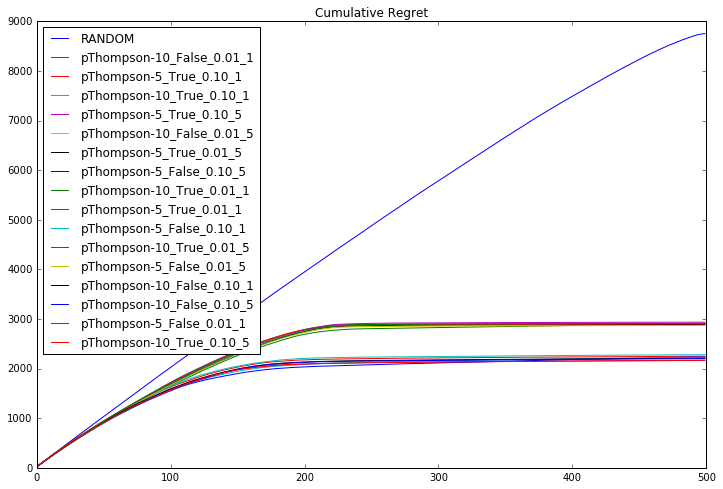

In [3]:
# compute cumulative regret for each configuration first
summary = dict()
for seq, nt, n_particle, rbp, var_x, mc_move in result:
    if not summary.__contains__((n_particle, rbp, var_x, mc_move)):
        summary[(n_particle, rbp, var_x, mc_move)] = np.zeros(max_iter)
        
    regret = compute_regret(T[nt], seq)
    summary[(n_particle, rbp, var_x, mc_move)] += np.cumsum(regret)

# plot cumulative regrets
fig = plt.figure(figsize=(12,8))
plt.plot(range(max_iter), random_regret/n_test, label='RANDOM')

for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    plt.plot(range(len(max_iter)), summary[key]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.legend(loc=0)
plt.title('Cumulative Regret')
plt.show()

## Which configuration performs best?

In [4]:
models = list()
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    final_regret = summary[key][-1]
    models.append((final_regret,'pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move)))
models.sort()
for model in models:
    print(model)    

(108255.79494862609, 'pThompson-10_True_0.10_5')
(108412.21027481586, 'pThompson-5_True_0.10_5')
(110017.73901362615, 'pThompson-10_False_0.10_5')
(110477.07063523619, 'pThompson-10_False_0.10_1')
(111224.24656019964, 'pThompson-5_False_0.10_1')
(111649.99507118043, 'pThompson-5_False_0.10_5')
(112478.15587768203, 'pThompson-5_True_0.10_1')
(113981.69575853585, 'pThompson-10_True_0.10_1')
(143469.2414082131, 'pThompson-5_False_0.01_5')
(144533.48124074779, 'pThompson-5_True_0.01_5')
(145019.67374512617, 'pThompson-5_True_0.01_1')
(145443.75529473994, 'pThompson-10_False_0.01_1')
(145472.03372212182, 'pThompson-10_True_0.01_1')
(145498.28618796059, 'pThompson-5_False_0.01_1')
(145680.27848275276, 'pThompson-10_False_0.01_5')
(146805.7951099154, 'pThompson-10_True_0.01_5')


## Cumulative Regret of First 200 Iterations

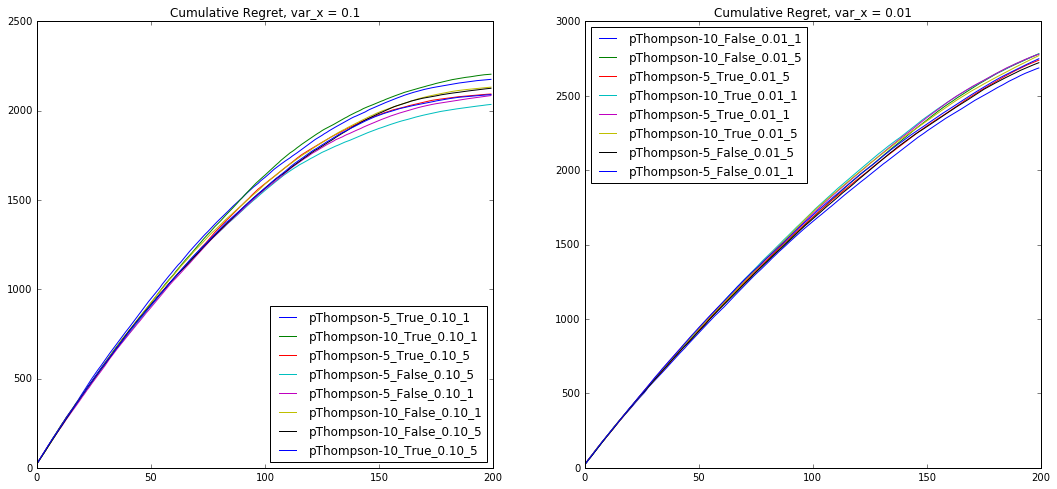

In [13]:
# plot cumulative regrets
fig = plt.figure(figsize=(18,8))
print_iter = 200
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    if var_x == 0.1:
        plt.subplot(1,2,1)
        plt.plot(range(print_iter), summary[key][:print_iter]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))
    else:
        plt.subplot(1,2,2)
        plt.plot(range(print_iter), summary[key][:print_iter]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.subplot(1,2,1)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.1')
plt.subplot(1,2,2)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.01')
plt.show()

## Cumulative Regret of After 200 Iterations

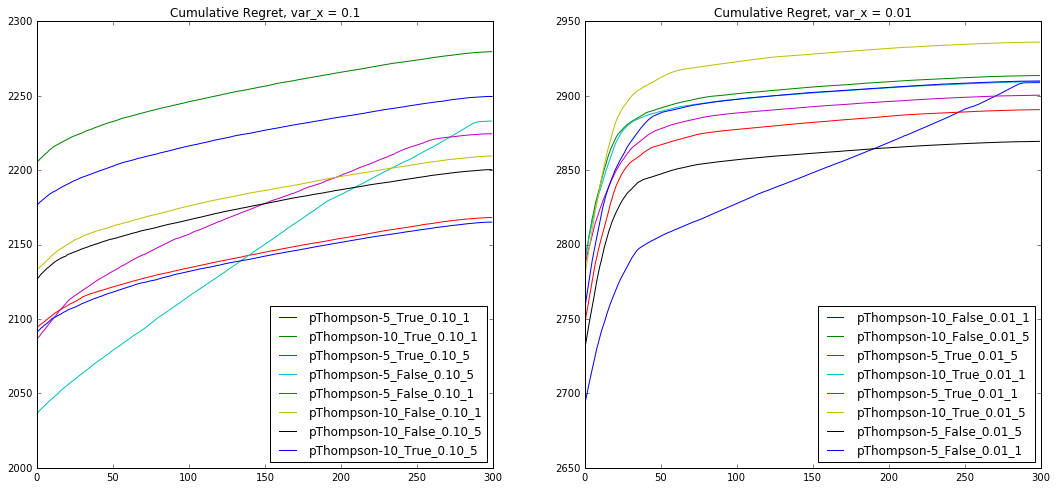

In [15]:
# plot cumulative regrets
fig = plt.figure(figsize=(18,8))
print_iter = 200
for key in summary.keys():
    n_particle, rbp, var_x, mc_move = key
    if var_x == 0.1:
        plt.subplot(1,2,1)
        plt.plot(range(max_iter-print_iter), summary[key][print_iter:]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))
    else:
        plt.subplot(1,2,2)
        plt.plot(range(max_iter-print_iter), summary[key][print_iter:]/n_test, label='pThompson-%d_%r_%.2f_%d' % (n_particle, rbp, var_x, mc_move))

plt.subplot(1,2,1)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.1')
plt.subplot(1,2,2)
plt.legend(loc=0)
plt.title('Cumulative Regret, var_x = 0.01')
plt.show()